In [53]:
import pandas as pd
import numpy as np
import pickle

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dense, Flatten, Activation
import time
from sklearn.metrics import r2_score
import kerastuner as kt

In [2]:
#https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
physical_devices

[]

In [4]:
#df_Polyimides.to_csv('polyimides.cvs')  

In [11]:
dataset1 = pd.read_csv('dataset1_imputed_all.csv')  
dataset1

,Unnamed: 0,index,Name,PID,Smiles,Details,Condition,Reference,Year,He,...,log10_O2_Bayesian,log10_N2_Bayesian,log10_CO2_Bayesian,log10_CH4_Bayesian,log10_He_Etree,log10_H2_Etree,log10_O2_Etree,log10_N2_Etree,log10_CO2_Etree,log10_CH4_Etree
0,0,0,polyethene,P010001,*C*,Dynamic method,"25 [C] ,","Pasternak, R. A.; Schimscheimer, J. F.; Heller...",1970,NaN,...,0.531479,-0.075721,1.110590,0.012254,1.201301,1.238196,0.531479,-0.075721,1.110590,-0.103039
1,1,1,polyethene,P010001,*C*,Dynamic method,"25 [C] ,","Pasternak, R. A.; Schimscheimer, J. F.; Heller...",1970,NaN,...,0.429002,-0.191294,1.037426,-0.101212,0.512792,0.845879,0.372675,-0.111720,1.037426,0.361122
2,2,2,polyethene,P010001,*C*,"Mocon Oxtran 100 equipment; P.S. Holden, G. A....","30 [C] ,","Holden, P. S.; Orchard, G. A. J.; Ward, I. M. ...",1985,NaN,...,-0.665546,-1.367414,-0.066764,-1.348410,0.803205,0.693273,-0.665546,-1.412270,-0.130830,-1.517954
3,3,3,polyethene,P010001,*C*,"Mocon Oxtran 100 equipment; P.S. Holden, G. A....","30 [C] ,","Holden, P. S.; Orchard, G. A. J.; Ward, I. M. ...",1985,NaN,...,-0.327902,-1.004516,0.274628,-0.963282,0.696047,0.613919,-0.327902,-1.146430,0.327439,-1.337536
4,4,4,polyethene,P010001,*C*,NaN,"25 [C] ,","Holden, P. S.; Orchard, G. A. J.; Ward, I. M. ...",1985,1.77,...,-0.013228,-0.490133,0.826281,-0.003425,0.247973,0.794222,-0.013228,-0.606161,0.774200,-0.306994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,773,313,Poly(2-adamanthyl vinyl ether),NaN,*CC(*)OC1C2CC3CC(C2)CC1C3,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,...,0.778874,0.227887,1.401401,0.360861,1.035338,1.350877,0.778874,0.227887,1.401401,0.498163
774,774,314,Poly(benzyl vinyl ether),NaN,*CC(*)OCc1ccccc1,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,...,0.367356,-0.102373,1.045323,0.067094,0.506273,0.849116,0.367356,-0.102373,1.045323,0.359446
775,775,315,Poly(cyclohexylmethyl vinyl ether),NaN,*CC(*)OCC1CCCCC1,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,...,0.190332,-0.397940,0.770115,-0.314109,0.966260,0.943327,0.190332,-0.397940,0.770115,-0.114003
776,776,316,Poly(8-tricyclo[5.2.1.0]decylmethyl vinyl ether),NaN,*CC(*)OCC1CC2CC1C1CCCC21,Vinyl and Vinylidene Polymers,NaN,http://dx.doi.org/10.1002/app.30834,2009,NaN,...,-0.091515,-0.886057,0.454845,-0.901289,0.922455,1.046136,-0.091515,-0.886057,0.454845,-1.037802


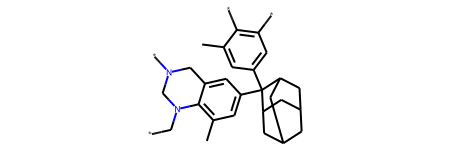

In [84]:
grouped = dataset1.groupby('Smiles').mean().reset_index()


()

In [12]:
fn = grouped['Smiles'].apply(Chem.MolFromSmiles).apply(lambda m: AllChem.GetMorganFingerprintAsBitVect(m, radius=3, nBits=2048))

In [13]:
X_fingerprint = np.array(fn.tolist())

In [14]:
X_fingerprint.shape

(778, 2048)

In [16]:
#choose columns with missing values, imputed bayesian, or imputed Etree
Y = dataset1.iloc[:,-18:-12]
Y

,log10_He,log10_H2,log10_O2,log10_N2,log10_CO2,log10_CH4
0,NaN,NaN,0.531479,-0.075721,1.110590,NaN
1,NaN,NaN,NaN,NaN,1.037426,NaN
2,NaN,NaN,-0.665546,NaN,NaN,NaN
3,NaN,NaN,-0.327902,NaN,NaN,NaN
4,0.247973,NaN,-0.013228,NaN,NaN,NaN
...,...,...,...,...,...,...
773,NaN,NaN,0.778874,0.227887,1.401401,NaN
774,NaN,NaN,0.367356,-0.102373,1.045323,NaN
775,NaN,NaN,0.190332,-0.397940,0.770115,NaN
776,NaN,NaN,-0.091515,-0.886057,0.454845,NaN


In [17]:
Y.max()

log10_He     4.250420
log10_H2     4.565848
log10_O2     4.857332
log10_N2     8.230449
log10_CO2    4.672098
log10_CH4    4.544068
dtype: float64

In [18]:
Y = Y / Y.max()

In [19]:
Y = Y.values

In [46]:
X = X_fingerprint
#X = X.astype('float64')

TypeError: Cannot interpret 'tf.float64' as a data type

In [38]:
#import keras.backend as K

dtype('float64')

In [22]:
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops

In [44]:
def nanmean_squared_error(y_true, y_pred):
    y_pred = ops.convert_to_tensor_v2(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    residuals = (y_true - y_pred)
    residuals_no_nan = tf.where(tf.math.is_nan(residuals), tf.zeros_like(residuals), residuals)
    sum_residuals = tf.reduce_sum(math_ops.squared_difference(residuals_no_nan , 0),-1) / tf.reduce_sum(tf.cast(~tf.math.is_nan(y_true), tf.float64),-1)
    return sum_residuals

In [45]:
xtrain, xtest, ytrain, ytest=train_test_split(X, Y, test_size=0.2, random_state=12)
print("xtrain:", xtrain.shape, "ytrain:", ytrain.shape)

model = Sequential()
model.add(Dense(8, input_dim=2048, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(6))

model.compile(loss=nanmean_squared_error, optimizer="Adam")
model.summary()
 
history = model.fit(xtrain, ytrain, epochs=100, batch_size=64, validation_data = ((xtest), ytest), verbose=2)

xtrain: (622, 2048) ytrain: (622, 6)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 8)                 16392     
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 54        
Total params: 16,518
Trainable params: 16,518
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


TypeError: in user code:

    C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    <ipython-input-44-f66a54ce9c22>:6 nanmean_squared_error  *
        sum_residuals = tf.reduce_sum(math_ops.squared_difference(residuals_no_nan , 0),-1) / tf.reduce_sum(tf.cast(~tf.math.is_nan(y_true), 'float64'),-1)
    C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_ops.py:1180 binary_op_wrapper
        raise e
    C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_ops.py:1164 binary_op_wrapper
        return func(x, y, name=name)
    C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_ops.py:1336 truediv
        return _truediv_python3(x, y, name)
    C:\Users\jason\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_ops.py:1267 _truediv_python3
        (x_dtype, y_dtype))

    TypeError: x and y must have the same dtype, got tf.float32 != tf.float64


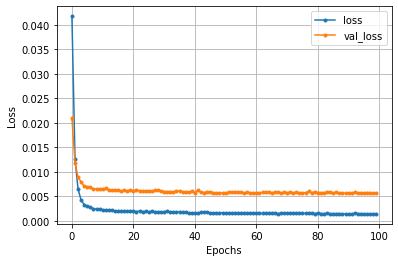

In [422]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig("./DNN_fingerprint_Loss.png", dpi=600, bbox_inches='tight')
plt.show()

In [423]:
Columns = ['TensileBreakValue','TensileModulusValue','TgValue']

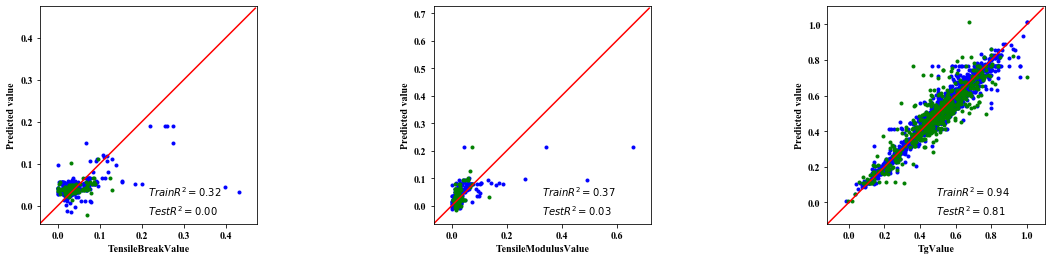

In [424]:
y_pred_train = model.predict((xtrain))
y_pred_test = model.predict((xtest))
plt.figure(figsize=(20,4))
for i in range(3):
    ax=plt.subplot(1, 3, i + 1)
    flag1 = ~np.isnan(ytrain[:,i])
    plt.plot(ytrain[:,i][flag1], y_pred_train[:,i][flag1], 'b.')#, alpha=0.8, label="Train R^2: {}".format(r2_score(y_train, y_pred_train)))
    flag2 = ~np.isnan(ytest[:,i])
    plt.plot(ytest[:,i][flag2], y_pred_test[:,i][flag2], 'g.')#, alpha=0.8, label="Test R^2: {}".format(r2_score(y_test, y_pred_test)))
    #plt.legend(loc = 'best')
    plt.xlabel(Columns[i],fontname="Times New Roman") #, fontsize=15
    plt.ylabel("Predicted value",fontname="Times New Roman") #, fontsize=15)
    x0, x1 = min(ytrain[:,i][flag1]), max(ytrain[:,i][flag1])
    length = x1 - x0
    x_start, x_end = x0-0.1*length, x1+0.1*length
    plt.xlim([x_start, x_end])
    plt.ylim([x_start, x_end])
    # ax.set_xticks([-200,-100,0,100,200,300,400,500])
    # ax.set_yticks([-200,-100,0,100,200,300,400,500])
    plt.xticks(fontname="Times New Roman") #, fontsize=15)
    plt.yticks(fontname="Times New Roman") #, fontsize=15)
    plt.gca().set_aspect("equal", adjustable="box")
    # the unit line
    plt.plot(np.arange(x_start, x_end, 0.01*length),
    np.arange(x_start, x_end, 0.01*length), 'r-')
    plt.text(x_end - 0.6*length, x_start + 0.15*length, "$Train R^2={:.2f}$".format(r2_score(ytrain[:,i][flag1], y_pred_train[:,i][flag1])))
    plt.text(x_end - 0.6*length, x_start + 0.05*length, "$Test R^2={:.2f}$".format(r2_score(ytest[:,i][flag2], y_pred_test[:,i][flag2])))
    #plt.savefig("./DNN_fingerprint.png", dpi=600, bbox_inches='tight')
    #plt.savefig("DNN_fingerprint.svg", bbox_inches='tight')